In [1]:
import pandas as pd
from pathlib import Path
import os
import errno, os, stat, shutil
from os import walk
import splitfolders

# Importing modules
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import train_test_split

np.random.seed(1)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [2]:
path_meta_csv = "data/HAM10000_metadata.csv"

df_file_neta_csv = pd.read_csv (path_meta_csv)

print(df_file_neta_csv)


         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


In [3]:
df_class_names_disease = df_file_neta_csv.groupby('dx').count()
df_class_names_disease.head(10)

,lesion_id,image_id,dx_type,age,sex,localization
dx,,,,,,
akiec,327,327,327,327,327,327
bcc,514,514,514,514,514,514
bkl,1099,1099,1099,1089,1099,1099
df,115,115,115,115,115,115
mel,1113,1113,1113,1111,1113,1113
nv,6705,6705,6705,6660,6705,6705
vasc,142,142,142,142,142,142


In [4]:


def handleRemoveReadonly(func, path, exc):
  excvalue = exc[1]
  if func in (os.rmdir, os.remove) and excvalue.errno == errno.EACCES:
      os.chmod(path, stat.S_IRWXU| stat.S_IRWXG| stat.S_IRWXO) # 0777
      func(path)
  else:
      raise


In [5]:
class_names_disease = df_class_names_disease.index.values

# Create folder for each case
path_base_processing = "data/processing_data"

if os.path.exists(path_base_processing):
    shutil.rmtree(path_base_processing, ignore_errors=False, onerror=handleRemoveReadonly)

path_base_train = "data/processing_data/train"
path_base_valid = "data/processing_data/valid"
path_base_batches = "data/processing_data/batches"

for item in class_names_disease:
    path_base_train_disease = path_base_train + "/" + item
    path_base_valid_disease = path_base_valid + "/" + item
    path_base_batches_disease = path_base_batches + "/" + item

    Path(path_base_train_disease).mkdir(parents=True, exist_ok=True)
    Path(path_base_valid_disease).mkdir(parents=True, exist_ok=True)
    Path(path_base_batches_disease).mkdir(parents=True, exist_ok=True)
    print(item)

akiec
bcc
bkl
df
mel
nv
vasc


In [6]:
# Copy all images to unique directory
path_images_ham10000_1 = "data/HAM10000_images_part_1"
path_images_ham10000_2 = "data/HAM10000_images_part_2"
path_all_images_ham10000 = "data/all_images_ham10000"

if os.path.exists(path_all_images_ham10000):
    shutil.rmtree(path_all_images_ham10000, ignore_errors=False, onerror=handleRemoveReadonly)

Path(path_all_images_ham10000).mkdir(parents=True, exist_ok=True)

files_1 = os.listdir(path_images_ham10000_1)
# iterating over all the files in
# the source directory
for fname in files_1:
    # copying the files to the
    # destination directory
    shutil.copy2(os.path.join(path_images_ham10000_1,fname), path_all_images_ham10000)

files_2 = os.listdir(path_images_ham10000_2)
# iterating over all the files in
# the source directory
for fname in files_2:
    # copying the files to the
    # destination directory
    shutil.copy2(os.path.join(path_images_ham10000_2,fname), path_all_images_ham10000)


In [7]:
df_imagesId_by_class_names_disease = df_file_neta_csv.groupby(by=['dx','image_id']).count()
df_imagesId_by_class_names_disease.head(10)

lesion_id  dx_type  age  sex  localization
dx    image_id                                                
akiec ISIC_0024329          1        1    1    1             1
      ISIC_0024372          1        1    1    1             1
      ISIC_0024418          1        1    1    1             1
      ISIC_0024450          1        1    1    1             1
      ISIC_0024463          1        1    1    1             1
      ISIC_0024468          1        1    1    1             1
      ISIC_0024470          1        1    1    1             1
      ISIC_0024511          1        1    1    1             1
      ISIC_0024517          1        1    1    1             1
      ISIC_0024522          1        1    1    1             1

In [8]:
Filter_df  = df_imagesId_by_class_names_disease[df_imagesId_by_class_names_disease.index.get_level_values('dx').isin(['nv'])]
Filter_df

lesion_id  dx_type  age  sex  localization
dx image_id                                                
nv ISIC_0024306          1        1    1    1             1
   ISIC_0024307          1        1    1    1             1
   ISIC_0024308          1        1    1    1             1
   ISIC_0024309          1        1    1    1             1
   ISIC_0024311          1        1    1    1             1
...                    ...      ...  ...  ...           ...
   ISIC_0034311          1        1    1    1             1
   ISIC_0034312          1        1    1    1             1
   ISIC_0034314          1        1    1    1             1
   ISIC_0034319          1        1    1    1             1
   ISIC_0034320          1        1    1    1             1

[6705 rows x 5 columns]

In [9]:
df_imagesId_by_class_names_disease.index.get_level_values('image_id').values

array(['ISIC_0024329', 'ISIC_0024372', 'ISIC_0024418', ...,
       'ISIC_0033991', 'ISIC_0034196', 'ISIC_0034214'], dtype=object)

In [10]:
# Copy each image in his respective folder by disease

for item in class_names_disease:
    print(f'Class: {item}')
    Filter_df  = df_imagesId_by_class_names_disease[df_imagesId_by_class_names_disease.index.get_level_values('dx').isin([item])]
    names_files_images = Filter_df.index.get_level_values('image_id').values

    Path(f'{path_all_images_ham10000}/{item}').mkdir(parents=True, exist_ok=True)

    for name in names_files_images:
        print(name)

        name_file = f'{name}.jpg'
        shutil.copy2(os.path.join(path_all_images_ham10000,name_file), f'{path_all_images_ham10000}/{item}')

        if os.path.exists(os.path.join(path_all_images_ham10000,name_file)):
            os.remove(os.path.join(path_all_images_ham10000,name_file))


Class: akiec
ISIC_0024329
ISIC_0024372
ISIC_0024418
ISIC_0024450
ISIC_0024463
ISIC_0024468
ISIC_0024470
ISIC_0024511
ISIC_0024517
ISIC_0024522
ISIC_0024539
ISIC_0024562
ISIC_0024575
ISIC_0024579
ISIC_0024646
ISIC_0024654
ISIC_0024707
ISIC_0024710
ISIC_0024763
ISIC_0024771
ISIC_0024800
ISIC_0024843
ISIC_0024913
ISIC_0024923
ISIC_0024925
ISIC_0024946
ISIC_0024948
ISIC_0025029
ISIC_0025069
ISIC_0025089
ISIC_0025130
ISIC_0025178
ISIC_0025182
ISIC_0025196
ISIC_0025247
ISIC_0025264
ISIC_0025319
ISIC_0025331
ISIC_0025350
ISIC_0025358
ISIC_0025368
ISIC_0025411
ISIC_0025427
ISIC_0025471
ISIC_0025539
ISIC_0025577
ISIC_0025605
ISIC_0025637
ISIC_0025696
ISIC_0025712
ISIC_0025780
ISIC_0025790
ISIC_0025803
ISIC_0025808
ISIC_0025811
ISIC_0025825
ISIC_0025831
ISIC_0025948
ISIC_0025953
ISIC_0025957
ISIC_0025992
ISIC_0026014
ISIC_0026040
ISIC_0026083
ISIC_0026100
ISIC_0026132
ISIC_0026138
ISIC_0026149
ISIC_0026152
ISIC_0026171
ISIC_0026178
ISIC_0026194
ISIC_0026203
ISIC_0026206
ISIC_0026212
ISIC_0026319

In [11]:
class_files = list()
for class_name in class_names_disease:
    folder_class = f'{path_all_images_ham10000}/{class_name}'
    #print(folder_class)
    for root,folder,files in walk(folder_class):
        #print(f'{class_name}')

        files_full_path = []

        for name_file in files:
            files_full_path.append(f'{path_all_images_ham10000}/{class_name}/{name_file}')

        aux_obj = {
            'class_name' : class_name,
            'files' : files_full_path
        }

        class_files.append(aux_obj
                           )
class_files

[{'class_name': 'akiec',
  'files': ['data/all_images_ham10000/akiec/ISIC_0024329.jpg',
   'data/all_images_ham10000/akiec/ISIC_0024372.jpg',
   'data/all_images_ham10000/akiec/ISIC_0024418.jpg',
   'data/all_images_ham10000/akiec/ISIC_0024450.jpg',
   'data/all_images_ham10000/akiec/ISIC_0024463.jpg',
   'data/all_images_ham10000/akiec/ISIC_0024468.jpg',
   'data/all_images_ham10000/akiec/ISIC_0024470.jpg',
   'data/all_images_ham10000/akiec/ISIC_0024511.jpg',
   'data/all_images_ham10000/akiec/ISIC_0024517.jpg',
   'data/all_images_ham10000/akiec/ISIC_0024522.jpg',
   'data/all_images_ham10000/akiec/ISIC_0024539.jpg',
   'data/all_images_ham10000/akiec/ISIC_0024562.jpg',
   'data/all_images_ham10000/akiec/ISIC_0024575.jpg',
   'data/all_images_ham10000/akiec/ISIC_0024579.jpg',
   'data/all_images_ham10000/akiec/ISIC_0024646.jpg',
   'data/all_images_ham10000/akiec/ISIC_0024654.jpg',
   'data/all_images_ham10000/akiec/ISIC_0024707.jpg',
   'data/all_images_ham10000/akiec/ISIC_0024710.

In [12]:
# Separación de las imagenes en carpetas de test, train, val según las categorías

path_final_images = "data_for_model"

if os.path.exists(path_final_images):
    shutil.rmtree(path_final_images, ignore_errors=False, onerror=handleRemoveReadonly)

Path(path_final_images).mkdir(parents=True, exist_ok=True)

splitfolders.ratio("data/all_images_ham10000", output=path_final_images, seed=1234, ratio=(.8, 0.1,0.1))

In [13]:
train_path = "data_for_model/train"
test_path = "data_for_model/test"
valid_path = "data_for_model/val"

class_disease_list = list()
for item in class_names_disease:
    class_disease_list.append(item)

class_disease_list

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

### Balancear clases

In [14]:
path_train_dm = "data_for_model/train"

labels = [] # Create some unbalanced dataset
files_images_classes = []
for c in class_disease_list:
    inside_folder = path_train_dm + "/" + c
    for f in os.listdir(inside_folder):
        image_path_file = inside_folder + "/" + f
        files_images_classes.append(image_path_file)
        labels.append(c)

In [15]:
df = pd.DataFrame({'img_path':files_images_classes,'label':labels})

In [16]:
def balance_data(df,target_size=5500):
    """
    Increase the number of samples to number_of_samples for every label

        Example:
        Current size of the label a: 10
        Target size: 23

        repeat, mod = divmod(target_size,current_size)
        2, 3 = divmod(23,10)

        Target size: current size * repeat + mod

    Repeat this example for every label in the dataset.
    """

    df_groups = df.groupby(['label'])
    df_balanced_result = pd.DataFrame({key:[] for key in df.keys()})

    for i in df_groups.groups.keys():
        df_group = df_groups.get_group(i)
        df_label = df_group.sample(frac=1)
        current_size = len(df_label)

        if current_size >= target_size:
            # If current size is big enough, do nothing
            pass
        else:

            # Repeat the current dataset if it is smaller than target_size
            repeat, mod = divmod(target_size,current_size)


            df_label_new = pd.concat([df_label]*repeat,ignore_index=True,axis=0)
            df_label_remainder = df_group.sample(n=mod)

            df_label_new = pd.concat([df_label_new,df_label_remainder],ignore_index=True,axis=0)

            # print(df_label_new)

        df_balanced_result = pd.concat([df_balanced_result, df_label_new], ignore_index=True, axis=0)


    return df_balanced_result

In [17]:
df_balanced = balance_data(df)
print(df_balanced)

                                          img_path  label
0      data_for_model/train/akiec/ISIC_0028224.jpg  akiec
1      data_for_model/train/akiec/ISIC_0030375.jpg  akiec
2      data_for_model/train/akiec/ISIC_0028158.jpg  akiec
3      data_for_model/train/akiec/ISIC_0027958.jpg  akiec
4      data_for_model/train/akiec/ISIC_0030487.jpg  akiec
...                                            ...    ...
38495   data_for_model/train/vasc/ISIC_0029889.jpg   vasc
38496   data_for_model/train/vasc/ISIC_0024706.jpg   vasc
38497   data_for_model/train/vasc/ISIC_0028188.jpg   vasc
38498   data_for_model/train/vasc/ISIC_0032867.jpg   vasc
38499   data_for_model/train/vasc/ISIC_0032240.jpg   vasc

[38500 rows x 2 columns]


In [18]:
df_balanced['label'].value_counts()

akiec    5500
bcc      5500
bkl      5500
df       5500
mel      5500
nv       5500
vasc     5500
Name: label, dtype: int64

In [19]:
batch_size = 200
BASE_MODEL = 'DenseNet121'

In [20]:
from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL == 'MobileNet':
    from keras.applications.mobilenet_v2 import MobileNetV2 as PTModel, preprocess_input
elif BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET52':
    from keras.applications.resnet import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='Xception':
    from keras.applications.xception import Xception as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169':
    from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet121':
    from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

In [21]:
# Creating train, test and valid batches from the respective directories
train_batches = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    rotation_range = 45,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.01,
    zoom_range = [0.9, 1.25],
    brightness_range = [0.7, 1.3],
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'reflect',
    data_format = 'channels_last',
    preprocessing_function=preprocess_input
).flow_from_dataframe(
            dataframe=df_balanced,
            x_col="img_path",
            y_col="label",
            class_mode="categorical",
            target_size=(224,224),
            classes=class_disease_list, batch_size=batch_size)


#train_batches = ImageDataGenerator(
#    rotation_range=10, # rotation
#    zoom_range=0.2, # zoom
#    horizontal_flip=True, # horizontal flip
#    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
#).flow_from_directory(directory=train_path, target_size=(224,224), classes=class_disease_list, batch_size=batch_size)

valid_batches = ImageDataGenerator(
    fill_mode = 'reflect',
    data_format = 'channels_last',
    preprocessing_function=preprocess_input
).flow_from_directory(directory=valid_path, target_size=(224,224), classes=class_disease_list, batch_size=batch_size)
test_batches = ImageDataGenerator(
    fill_mode = 'reflect',
    data_format = 'channels_last',
    preprocessing_function=preprocess_input
).flow_from_directory(directory=test_path, target_size=(224,224), classes=class_disease_list, batch_size=batch_size,  shuffle=False)

Found 38500 validated image filenames belonging to 7 classes.
Found 998 images belonging to 7 classes.
Found 1007 images belonging to 7 classes.


Target_size especifica a qué altura y anchura queremos que se cambie el tamaño de las imágenes. Esto es importante ya que podríamos tener imágenes de diferentes tamaños en nuestro conjunto de datos.
El tamaño de batch se establece en 10 y la elección de 10 es arbitraria. Otro valor de tamaño de batch común utilizado en 32, pero idealmente, el valor más óptimo debe encontrarse mediante el ajuste de hiperparámetros.
El tamaño de batch especifica cuántas muestras de entrenamiento se deben pasar a la red neuronal de una sola vez antes de que se actualicen los pesos de la red neuronal.
También especificamos shuffle = False solo para el conjunto de prueba porque más adelante, cuando probamos nuestro modelo, queremos tener acceso a etiquetas no mezcladas para trazar nuestra matriz de confusión. De forma predeterminada, la reproducción aleatoria está establecida en Verdadero.

### Visualizamos los datos:

In [22]:
# Graficamos imágenes en forma de cuadrícula de 1 por 10 y cambiamos el tamaño de la imagen a 20x20
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img.astype(np.uint8))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

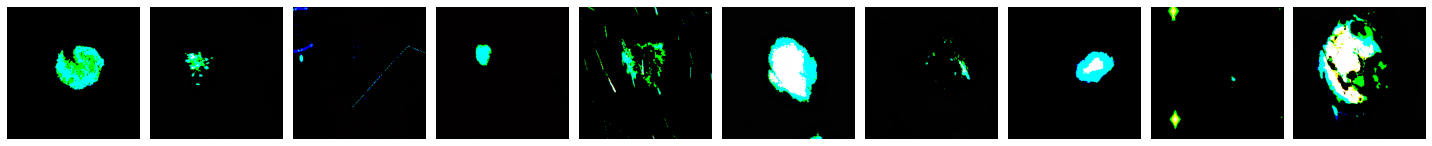

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [23]:
imgs, labels = next(train_batches)
plotImages(imgs)
print(labels)

### Generando la arquitectura del modelo

In [24]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"],cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

with mirrored_strategy.scope():

    # Creating train, test and valid batches from the respective directories
    train_batches = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        rotation_range = 45,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.01,
        zoom_range = [0.9, 1.25],
        brightness_range = [0.7, 1.3],
        horizontal_flip = True,
        vertical_flip = False,
        fill_mode = 'reflect',
        data_format = 'channels_last',
        preprocessing_function=preprocess_input
    ).flow_from_dataframe(
                dataframe=df_balanced,
                x_col="img_path",
                y_col="label",
                class_mode="categorical",
                target_size=(224,224),
                classes=class_disease_list, batch_size=batch_size)


    #train_batches = ImageDataGenerator(
    #    rotation_range=10, # rotation
    #    zoom_range=0.2, # zoom
    #    horizontal_flip=True, # horizontal flip
    #    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
    #).flow_from_directory(directory=train_path, target_size=(224,224), classes=class_disease_list, batch_size=batch_size)

    valid_batches = ImageDataGenerator(
        fill_mode = 'reflect',
        data_format = 'channels_last',
        preprocessing_function=preprocess_input
    ).flow_from_directory(directory=valid_path, target_size=(224,224), classes=class_disease_list, batch_size=batch_size)
    test_batches = ImageDataGenerator(
        fill_mode = 'reflect',
        data_format = 'channels_last',
        preprocessing_function=preprocess_input
    ).flow_from_directory(directory=test_path, target_size=(224,224), classes=class_disease_list, batch_size=batch_size,  shuffle=False)

    model = Sequential([
        #Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
        #MaxPool2D(pool_size=(2, 2), strides=2),
        #Conv2D(filters=30, kernel_size=(3, 3), activation='relu', padding = 'same'),
        #MaxPool2D(pool_size=(2, 2), strides=2),
        #Conv2D(filters=30, kernel_size=(3, 3), activation='relu', padding = 'same'),
        #MaxPool2D(pool_size=(2, 2), strides=2),

        #Conv2D(kernel_size=(3,3), filters=32, activation='tanh', input_shape=(224,224,3)),
        #Conv2D(filters=32,kernel_size = (3,3),activation='tanh'),
        #MaxPool2D(2,2),
        #Conv2D(filters=32,kernel_size = (3,3),activation='tanh'),
        #MaxPool2D(2,2),
        #Conv2D(filters=32,kernel_size = (3,3),activation='tanh'),
        #Flatten(),


        Conv2D(kernel_size=(3,3), filters=32, activation='relu', input_shape=(224,224,3)),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Dropout(0.2),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Dropout(0.2),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Dropout(0.2),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Dropout(0.2),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Dropout(0.2),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Dropout(0.2),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Dropout(0.2),
        BatchNormalization(),

        #Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
        #MaxPool2D(pool_size=(2, 2), strides=2),
        #Dropout(0.2),
        #BatchNormalization(),

        #Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
        #MaxPool2D(pool_size=(2, 2), strides=2),
        #Dropout(0.2),
        #BatchNormalization(),

        Flatten(),
        Dropout(0.2),

        Dense(700, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),

        Dropout(.2),
        Dense(350, activation='relu'),

        #Dense(224, activation='relu'),
        #Dropout(.2),
        #Dense(224, activation='relu'),
        #Dropout(.2),
        #Dense(224, activation='relu'),
        #Dropout(.2),
        #Dense(224, activation='relu'),
        #Dropout(.2),
        #Dense(224, activation='relu'),
        #Dropout(.2),
        #Dense(224, activation='relu'),
        #Dropout(.2),
        #Dense(224, activation='relu'),
        #Dense(224, activation='relu'),

        Dense(units=7, activation='softmax')
    ])

    # Preparando el modelo para el entrenamiento
    model.compile(
                  loss='categorical_crossentropy',
                  metrics=['acc'],
                  optimizer=Adam(learning_rate=0.001)
                 )


    history = model.fit(
        x = train_batches,
        steps_per_epoch=train_batches.samples // batch_size,
        epochs=25,
        validation_data=valid_batches,
        validation_steps=valid_batches.samples // batch_size,
        verbose=1
    )


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Found 38500 validated image filenames belonging to 7 classes.
Found 998 images belonging to 7 classes.
Found 1007 images belonging to 7 classes.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:t

Antes de comenzar a entrenar nuestro modelo con datos reales, debemos compilar el modelo con ciertos parámetros. Aquí, usaremos el optimizador de Adam. El parámetro de pérdida especifica que la pérdida de entropía cruzada categórica debe monitorearse en cada iteración. El parámetro de métricas indica que queremos juzgar nuestro modelo en función de la precisión.

La primera capa oculta es una capa convolucional estándar, Conv2D, con 32 filtros cada uno con un tamaño de kernel de 3x3. Recuerda que cada filtro está dedicado a identificar algún aspecto de la imagen, digamos que el filtro1 detecta los límites verticales de la caja torácica, el filtro2 detecta los límites diagonales de la caja torácica, etc. profundizar en las capas convolucionales de la red.
Nota: ¡La elección de 32 es arbitraria!

Un kernel es una pequeña cuadrícula de números y la pasamos por toda la imagen, es decir, todos los píxeles de la imagen de entrada, y la transformamos en función de esos números. Al usar diferentes números en los kernel, podemos realizar diferentes tipos de preprocesamiento de imágenes (durante el reconocimiento de imágenes) como contraste, desenfoque, nitidez o detección de bordes.

Tenemos que crear el parámetro input_shape basado en nuestro propio conjunto de datos. Básicamente, se puede pensar como la forma de una sola imagen que se alimenta a la red, que en nuestro caso es 224x224x3 (alto = ancho = 224 y 3 es para el canal de color, más precisamente el componente RGB).

Cuando un kernel alcanza el borde de la imagen, tiene que tomar una decisión sobre qué hacer cuando no hay píxeles presentes en la imagen de entrada. Por ahora, vamos a rellenar con ceros los bordes, que se consigue utilizando padding = 'same'. El Zero padding significa proporcionar un colchón de ceros fuera de la imagen. Esto ayuda a garantizar que la dimensionalidad de la imagen de entrada no se reduzca después de la operación de convolución.

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0

In [26]:
# recordemos que configuramos batch_size = 10 durante el preprocesamiento
#batch_size = 10



# Run training on GPU
#with tf.device('/gpu:1'):



Si observamos con atención, no hemos indicado explícitamente las etiquetas para el conjunto de entrenamiento y la razón es que ya están incorporadas en el iterador train_batches.

### Evaluamos el modelo

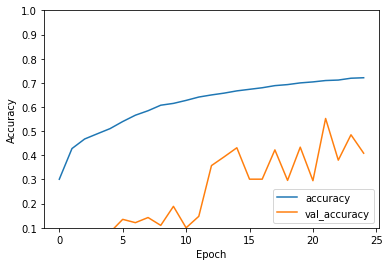

In [27]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

Como podemos apreciar, definitivamente se está produciendo un sobreajuste ya que la precisión del conjunto de entrenamiento es del 100% y el loss del conjunto de entrenamiento es casi insignificante, pero la precisión en el conjunto de validación es solo del 75%. Pero bueno, incluso con una arquitectura de modelo tan básica y solo seis capas ocultas, ¡esto no está nada mal, para empezar!

### Hacemos inferencias sobre el dataset de test

In [28]:
predictions = model.predict(x = test_batches, verbose=0)

### Visualización de los resultados de la predicción mediante una matriz de confusión

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 16   8   6   3   1   0   0]
 [  3  37   7   5   0   0   0]
 [  6  11  83   5   1   5   0]
 [  1   1   2   8   0   0   0]
 [  4   5  80   4   9  10   0]
 [ 10  51 323  61   8 218   0]
 [  0   7   0   2   0   0   6]]


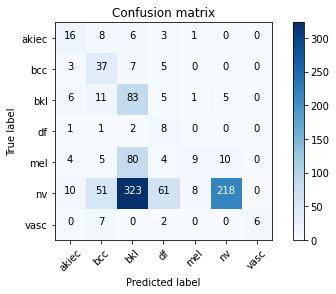

In [30]:
# confusion matrix
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm, classes = class_disease_list)

In [31]:
# Model evaluation
scores = model.evaluate(test_batches, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 37.44%
